In [1]:
# Dependent variable data preprocessing

import pandas as pd

df = pd.read_csv('raw_datasets/main_dataset/forecasts_and_truth.csv', low_memory=False)
filtered_df = df[df['target_variable'] == 'inc case']
filtered_df = filtered_df[filtered_df['abbreviation'] != 'US']
filtered_df = filtered_df.drop_duplicates(subset=['target_end_date', 'abbreviation'], keep='first')
result_df = filtered_df[['target_end_date', 'abbreviation', 'truth_value']]
result_df.rename(columns={'abbreviation': 'location_key', 'truth_value': 'inc cases'}, inplace=True)
result_df['location_key'] = 'US_' + result_df['location_key']
result_df.to_csv('week5_data/filtered_main_dataset.csv', index=False)

C:\Users\kalei\AppData\Local\Temp\ipykernel_28088\601584150.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.rename(columns={'abbreviation': 'location_key', 'truth_value': 'inc cases'}, inplace=True)
C:\Users\kalei\AppData\Local\Temp\ipykernel_28088\601584150.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['location_key'] = 'US_' + result_df['location_key']


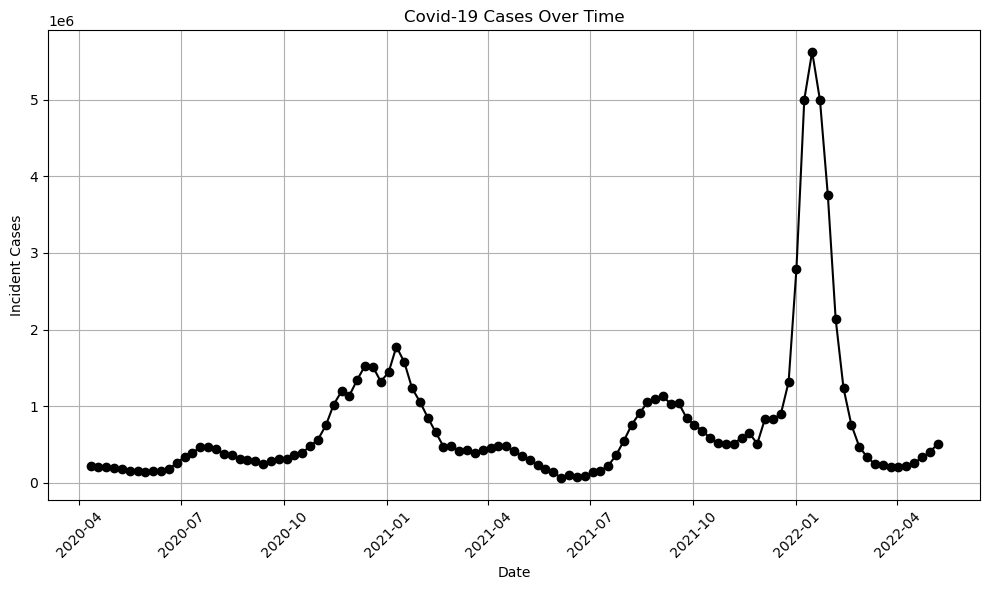

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

main_csv_path = 'week5_data/filtered_main_dataset.csv'
df = pd.read_csv(main_csv_path, low_memory=False)

df['target_end_date'] = pd.to_datetime(df['target_end_date'])

overall_df = df.groupby('target_end_date')['inc cases'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(overall_df['target_end_date'], overall_df['inc cases'], color='black', marker='o', linestyle='-')

date_locator = AutoDateLocator()
date_formatter = AutoDateFormatter(date_locator)
plt.gca().xaxis.set_major_locator(date_locator)
plt.gca().xaxis.set_major_formatter(date_formatter)

plt.title('Covid-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Incident Cases')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [3]:
# Independent variable data preprocessing

import pandas as pd
import os

main_csv_path = 'week5_data/filtered_main_dataset.csv'
csv_folder_path = 'raw_datasets/supplementary_dataset_TS'

main_df = pd.read_csv(main_csv_path, low_memory=False)
main_df['target_end_date'] = pd.to_datetime(main_df['target_end_date'])

columns_to_sum = ['new_hospitalized_patients', 'new_persons_fully_vaccinated']
columns_to_average = ['stringency_index', 
                      'average_temperature_celsius', 
                      'search_trends_common_cold']

final_aggregated_data = None  # Start with None for easier checking later

location_keys = set(main_df['location_key'])

for file in os.listdir(csv_folder_path):
    if file.endswith(".csv"):
        file_path = os.path.join(csv_folder_path, file)
        daily_df = pd.read_csv(file_path, low_memory=False)
        daily_df['date'] = pd.to_datetime(daily_df['date'], format="%Y-%m-%d", errors='coerce')
        daily_df = daily_df[daily_df['location_key'].isin(location_keys) & daily_df['date'].notna()]

        # Filter columns available for sum and average to prevent KeyError
        available_columns_to_sum = [col for col in columns_to_sum if col in daily_df.columns]
        available_columns_to_average = [col for col in columns_to_average if col in daily_df.columns]

        if available_columns_to_sum or available_columns_to_average:
            # Group by 'location_key' and 'week_end_date', and perform necessary aggregations
            grouped = daily_df.groupby(['location_key', daily_df['date'].dt.to_period('W-SAT').dt.to_timestamp('W-SAT')])
            aggregated = grouped.agg({**{col: 'sum' for col in available_columns_to_sum},
                                      **{col: 'mean' for col in available_columns_to_average}}).reset_index().rename(columns={'date': 'week_end_date'})

            # Merge this file's aggregated data into the final DataFrame
            if final_aggregated_data is None:
                final_aggregated_data = aggregated
            else:
                final_aggregated_data = pd.merge(final_aggregated_data, aggregated, on=['week_end_date', 'location_key'], how='outer', suffixes=('', '_dup'))

                # Handle any duplicate columns if they exist by averaging sum and mean columns, if required
                for col in set(available_columns_to_sum + available_columns_to_average):
                    if f'{col}_dup' in final_aggregated_data:
                        final_aggregated_data[col] = final_aggregated_data[[col, f'{col}_dup']].mean(axis=1)
                        final_aggregated_data.drop(columns=[f'{col}_dup'], inplace=True)

# Sort the final aggregated data by 'week_end_date'
final_aggregated_data = final_aggregated_data.sort_values(by='week_end_date')

# Filter final_aggregated_data to only include target_end_dates present in the main_df
final_aggregated_data = final_aggregated_data[final_aggregated_data['week_end_date'].isin(main_df['target_end_date'])]

# Ensure 'week_end_date' is the first column
col_order = ['week_end_date'] + [col for col in final_aggregated_data.columns if col != 'week_end_date']
final_aggregated_data = final_aggregated_data[col_order]

final_aggregated_data.rename(columns={'week_end_date': 'target_end_date'}, inplace=True)

final_aggregated_data = pd.merge(final_aggregated_data, main_df, on=['target_end_date', 'location_key'], how='outer', suffixes=('', '_dup'))

# Save the filtered and reordered aggregated data to a CSV file
output_path = 'week5_data/weekly_aggregated_sup_data.csv'
final_aggregated_data.to_csv(output_path, index=False)

print(f"Filtered and ordered aggregated data saved to {output_path}")

Filtered and ordered aggregated data saved to week5_data/weekly_aggregated_sup_data.csv


In [4]:
import numpy as np

df = pd.read_csv('week5_data/weekly_aggregated_sup_data.csv')

df['log_inc_cases'] = np.log(df['inc cases'] + 1)
df['log_new_hospitalized_patients'] = np.log(df['new_hospitalized_patients'] + 1)
df['log_new_persons_fully_vaccinated'] = np.log(df['new_persons_fully_vaccinated'] + 1)

df.to_csv('week5_data/log_weekly_aggregated_sup_data.csv', index=False)

c:\Users\kalei\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kalei\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kalei\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kalei\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
# Missing data percentage calculation

import pandas as pd
import numpy as np

results_df = pd.read_csv('week5_data/weekly_aggregated_sup_data.csv')

missing_value_percentages = results_df.select_dtypes(include=[np.number]).isnull().mean().sort_values() * 100

print(missing_value_percentages)

average_temperature_celsius      0.000000
inc cases                        1.245085
new_hospitalized_patients        2.342726
search_trends_common_cold        8.928571
stringency_index                 8.928571
new_persons_fully_vaccinated    36.697248
dtype: float64


In [6]:
# Main dataset regression (without deduce 0 variance variables)

import pandas as pd
import statsmodels.api as sm

# Load the dataset
final_dataset = pd.read_csv('week5_data/weekly_aggregated_sup_data.csv')

# Define the dependent variable
Y = final_dataset['inc cases']

# Create dummy variables for 'location_key' before defining X and y
final_dataset = pd.get_dummies(final_dataset, columns=['location_key'], drop_first=True, dtype=float)

# List of selected variables (assumed after location_key dummies are created)
selected_variables = [
    'new_hospitalized_patients', 
    'new_persons_fully_vaccinated',
    'stringency_index', 
    'average_temperature_celsius', 
    'search_trends_common_cold', 
] + [col for col in final_dataset.columns if 'location_key_' in col]  # This includes all dummy variables for location_key

# Fill missing values for the selected numerical columns
for column in selected_variables:
    if column in final_dataset and final_dataset[column].dtype != 'object':
        final_dataset[column].fillna(final_dataset[column].mean(), inplace=True)
        
# Define X with selected variables including dummy variables
X = final_dataset[selected_variables]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Ensure 'y' is numeric and handle missing values
Y = pd.to_numeric(Y, errors='coerce').fillna(Y.mean())

# Fit the OLS model
model = sm.OLS(Y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              inc cases   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     241.8
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:01:17   Log-Likelihood:                -68596.
No. Observations:                6104   AIC:                         1.373e+05
Df Residuals:                    6043   BIC:                         1.377e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [3]:
# Main dataset regression (without deduce 0 variance variables)

import pandas as pd
import statsmodels.api as sm

# Load the dataset
final_dataset = pd.read_csv('week5_data/weekly_aggregated_sup_data.csv')

blue_states_list = ['US_CA', 'US_ME', 'US_OR', 'US_CO', 'US_MD', 'US_RI', 'US_CT', 'US_MA', 'US_VT', 'US_DE', 'US_NH', 'US_VA', 'US_DC', 'US_NJ', 'US_WA', 'US_HI', 'US_NM', 'US_NY', 'US_IL']
red_states_list = ['US_AL', 'US_AK', 'US_AR', 'US_ID', 'US_IN', 'US_IA', 'US_KS', 'US_KY', 'US_LA', 'US_MS', 'US_MO', 'US_MT', 'US_NE', 'US_ND', 'US_OK', 'US_SC', 'US_SD', 'US_TN', 'US_TX', 'US_UT', 'US_WV', 'US_WY']

# Set 1 for blue states and 0 for others
final_dataset['blue_states'] = final_dataset['location_key'].apply(lambda x: 1 if x in blue_states_list else 0)

# Set 1 for red states and 0 for others
final_dataset['red_states'] = final_dataset['location_key'].apply(lambda x: 1 if x in red_states_list else 0)

# US_AZ, US_NV, US_FL, US_NC, US_GA, US_OH, US_MI, US_PA, US_MN, US_WI
# Set 1 for swing states and 0 for others
swing_states_list = ['US_AZ', 'US_NV', 'US_FL', 'US_NC', 'US_GA', 'US_OH', 'US_MI', 'US_PA', 'US_MN', 'US_WI']
final_dataset['swing_states'] = final_dataset['location_key'].apply(lambda x: 1 if x in swing_states_list else 0)

# Define the dependent variable
Y = final_dataset['inc cases']

# List of selected variables (assumed after location_key dummies are created)
selected_variables = [
    'new_hospitalized_patients', 
    'new_persons_fully_vaccinated',
    'stringency_index', 
    'average_temperature_celsius', 
    'search_trends_common_cold', 
] + ['blue_states', 'red_states', 'swing_states']  # This includes all dummy variables for location_key

# Fill missing values for the selected numerical columns
for column in selected_variables:
    if column in final_dataset and final_dataset[column].dtype != 'object':
        final_dataset[column].fillna(final_dataset[column].mean(), inplace=True)
        
# Define X with selected variables including dummy variables
X = final_dataset[selected_variables]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Ensure 'y' is numeric and handle missing values
Y = pd.to_numeric(Y, errors='coerce').fillna(Y.mean())

# Fit the OLS model
model = sm.OLS(Y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              inc cases   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     1644.
Date:                Tue, 07 May 2024   Prob (F-statistic):               0.00
Time:                        15:31:29   Log-Likelihood:                -68822.
No. Observations:                6104   AIC:                         1.377e+05
Df Residuals:                    6095   BIC:                         1.377e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [7]:
import numpy as np

predictions = model.predict(X)

# Errors
errors = Y - predictions

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(errors))

# Mean Squared Error (MSE)
mse = np.mean(errors**2)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
aic = model.aic

print("IV Mean:", Y.mean())
print("IV Median", Y.median())
print("MAE:", mae)
print("RMSE:", rmse)
print("AIC:", aic)

IV Mean: 13512.52090245521
IV Median 4659.0
MAE: 7312.62941208455
RMSE: 18378.549015112
AIC: 137314.01440810686


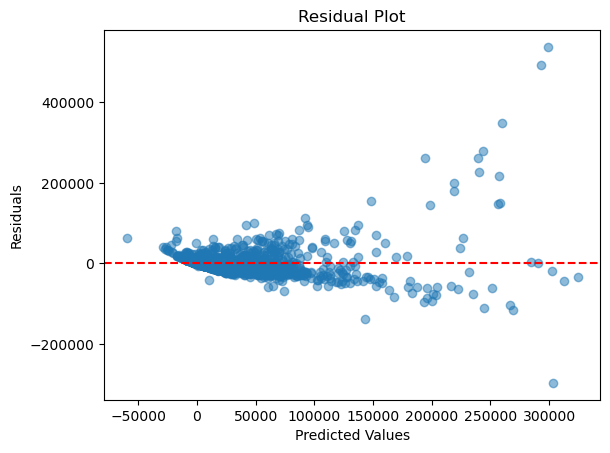

In [8]:
import matplotlib.pyplot as plt

# Residual Plot
plt.scatter(predictions, errors, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

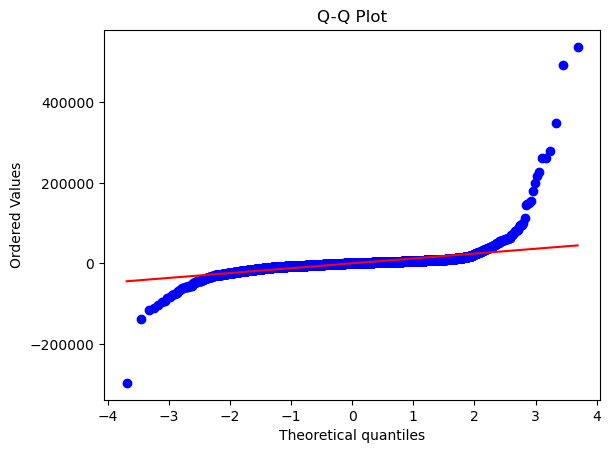

In [9]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Q-Q plot
stats.probplot(errors, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_vif = X.loc[:, ~X.columns.str.startswith('location_key')]
X_vif = X_vif.drop(columns=['const'], errors='ignore')

# calculate VIF for each feature
def calculate_vifs(X):
    vif_data = pd.DataFrame()
    vif_data["variable"] = X.columns

    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data

vif_data = calculate_vifs(X_vif)

# Filter out variables with VIF greater than a threshold (commonly 5 or 10)
print(vif_data[vif_data["VIF"] > 0].sort_values(by="VIF", ascending=False))

                       variable       VIF
2              stringency_index  5.513214
4     search_trends_common_cold  5.021403
3   average_temperature_celsius  2.532684
1  new_persons_fully_vaccinated  1.530287
0     new_hospitalized_patients  1.511345


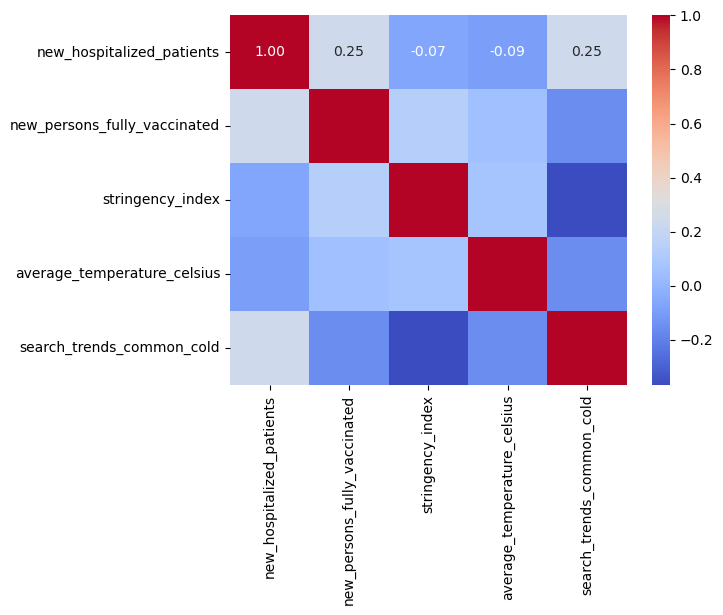

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

filtered_X = X.loc[:, ~X.columns.str.startswith('location_key')]
filtered_X = filtered_X.loc[:, filtered_X.std() > 0]
corr = filtered_X.corr()

# heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [12]:
# Main dataset regression (0 variance variables deduced)

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('week5_data/weekly_aggregated_sup_data.csv', low_memory=False)

# Select predictors and target variable before dropping missing values
X = df[[
    'inc cases',
    'location_key',
    'new_hospitalized_patients', 
    'new_persons_fully_vaccinated',
    'stringency_index', 
    'average_temperature_celsius', 
    'search_trends_common_cold', ]]

# Drop rows with missing values in any selected variable or the target
data_cleaned = X.dropna(axis=0, how='any')

# Separate predictors and target variable after cleaning
y_cleaned = data_cleaned['inc cases']
X_cleaned = data_cleaned.drop(columns=['inc cases'])

# One-hot encoding categorical variables and dropping the first dummy to avoid multicollinearity
X_encoded = pd.get_dummies(X_cleaned, columns=['location_key'], drop_first=True).astype(int)

# Drop variables with 0 variability (no information) or high correlation (multicollinearity)

# VarianceThreshold with a threshold of 0 (default) to remove 0 variance columns
selector = VarianceThreshold()
X_encoded_var_filtered = selector.fit_transform(X_encoded)
# Get the columns after variance thresholding
X_encoded_var_filtered = X_encoded.iloc[:, selector.get_support(indices=True)]

# Calculate the correlation matrix (absolute value - we don't care about direction of correlation)
corr_matrix = X_encoded_var_filtered.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to keep track of columns to drop
to_drop = []

# Iterate over the columns of the upper triangle
for column in upper_tri.columns:
    for row in upper_tri.index:
        # Check if the correlation is above the threshold and the column hasn't been considered yet
        if upper_tri.loc[row, column] > 0.9 and column not in to_drop and row not in to_drop:
            to_drop.append(column)
            break  # Break the loop once a column is marked for dropping

# 'to_drop' contains columns where only one of each highly correlated pair is considered for dropping

# Drop highly correlated features 
X_encoded_final = X_encoded_var_filtered.drop(columns=to_drop)

# Standardise features to help with interpretation 

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_encoded_final)

# Apply transform to both the training set and the test set
X_train_scaled = pd.DataFrame(scaler.transform(X_encoded_final), columns=X_encoded_final.columns, index=X_encoded_final.index)

# Adding a constant for the intercept
X_encoded_with_const = sm.add_constant(X_train_scaled)

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

# Fitting the linear regression model
model = sm.OLS(y_cleaned, X_encoded_with_const ).fit()

# Displaying the regression results
print(model.summary())

C:\Users\kalei\AppData\Local\Temp\ipykernel_28088\2331323617.py:75: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                            OLS Regression Results                            
Dep. Variable:              inc cases   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     176.5
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:01:18   Log-Likelihood:                -40049.
No. Observations:                3519   AIC:                         8.021e+04
Df Residuals:                    3463   BIC:                         8.055e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [13]:
import numpy as np

predictions = model.predict(X_encoded_with_const)

# Errors
errors = y_cleaned - predictions

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(errors))

# Mean Squared Error (MSE)
mse = np.mean(errors**2)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

aic = model.aic

print("IV Mean:", y_cleaned.mean())
print("IV Median", y_cleaned.median())
print("MAE:", mae)
print("RMSE:", rmse)
print("AIC:", aic)

IV Mean: 16756.554703040638
IV Median 5841.0
MAE: 8967.579424780299
RMSE: 21200.771120874084
AIC: 80209.58735974538


Log transformation model

In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load the dataset
final_dataset = pd.read_csv('week5_data/weekly_aggregated_sup_data.csv').drop(columns=['target_end_date'])

# Apply log transformation to the dependent variable and selected independent variables
# Ensure to add 1 to avoid log(0)
final_dataset['log_inc_cases'] = np.log(final_dataset['inc cases'] + 1)
final_dataset['log_new_hospitalized_patients'] = np.log(final_dataset['new_hospitalized_patients'] + 1)
final_dataset['log_new_persons_fully_vaccinated'] = np.log(final_dataset['new_persons_fully_vaccinated'] + 1)

# Update the dataset with dummy variables for 'location_key'
final_dataset = pd.get_dummies(final_dataset, columns=['location_key'], drop_first=True, dtype=float)

# Updated list of selected variables including the log-transformed variables
selected_variables_transformed = [
    'log_new_hospitalized_patients', 
    # 'log_new_persons_fully_vaccinated',
    'stringency_index', 
    'average_temperature_celsius', 
    'search_trends_common_cold'
] + [col for col in final_dataset.columns if 'location_key_' in col]

# Fill missing values for numerical columns
final_dataset[selected_variables_transformed] = final_dataset[selected_variables_transformed].fillna(final_dataset[selected_variables_transformed].mean())

# Handling infinite values possibly introduced by log transformation
final_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
final_dataset.fillna(final_dataset.mean(), inplace=True)

# Define the dependent and independent variables
X = final_dataset[selected_variables_transformed]
Y = final_dataset['log_inc_cases']

# Adding a constant for the intercept
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(Y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          log_inc_cases   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     362.7
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:05:49   Log-Likelihood:                -8253.1
No. Observations:                6104   AIC:                         1.663e+04
Df Residuals:                    6044   BIC:                         1.703e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

c:\Users\kalei\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kalei\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kalei\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kalei\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
import numpy as np

predictions = model.predict(X)

# Errors
errors = Y - predictions

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(errors))

# Mean Squared Error (MSE)
mse = np.mean(errors**2)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
aic = model.aic

print("IV Log mean:", Y.mean())
print("IV Log median", Y.median())
print("MAE:", mae)
print("RMSE:", rmse)
print("AIC:", aic)

IV Log mean: 8.154094153618914
IV Log median 8.399647115226195
MAE: 0.645312776026059
RMSE: 0.9353256953588109
AIC: 16626.168958165043


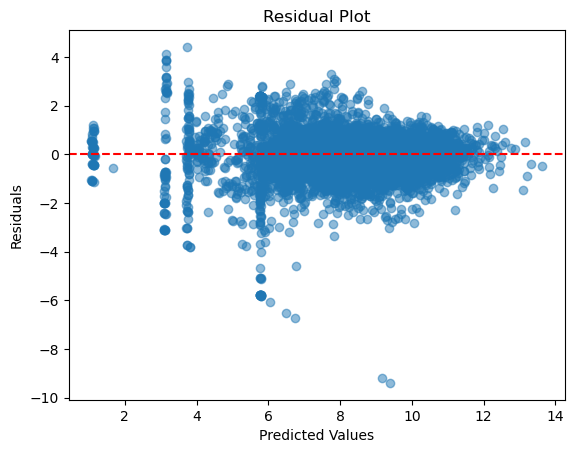

In [16]:
import matplotlib.pyplot as plt

# Residual Plot
plt.scatter(predictions, errors, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

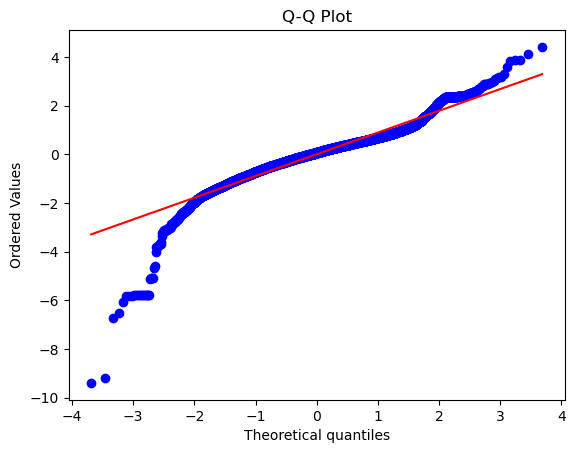

In [17]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Q-Q plot
stats.probplot(errors, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_vif = X.loc[:, ~X.columns.str.startswith('location_key')]
X_vif = X_vif.drop(columns=['const'], errors='ignore')

# calculate VIF for each feature
def calculate_vifs(X):
    vif_data = pd.DataFrame()
    vif_data["variable"] = X.columns

    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data

vif_data = calculate_vifs(X_vif)

# Filter out variables with VIF greater than a threshold (commonly 5 or 10)
print(vif_data[vif_data["VIF"] > 0].sort_values(by="VIF", ascending=False))

                        variable       VIF
3      search_trends_common_cold  7.311183
0  log_new_hospitalized_patients  6.131498
1               stringency_index  5.587224
2    average_temperature_celsius  2.510442


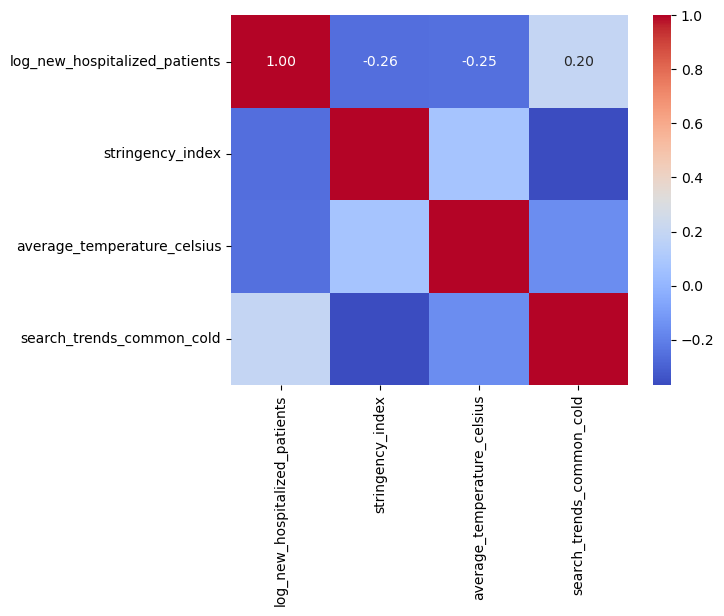

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

filtered_X = X.loc[:, ~X.columns.str.startswith('location_key')]
filtered_X = filtered_X.loc[:, filtered_X.std() > 0]
corr = filtered_X.corr()

# heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

final_dataset = pd.read_csv('week5_data/weekly_aggregated_sup_data.csv')

selected_variables = [
    'new_hospitalized_patients', 
    'new_persons_fully_vaccinated',
    'stringency_index', 
    'average_temperature_celsius', 
    'search_trends_common_cold',
]

# Define X and y from the final_dataset
X = final_dataset[selected_variables]
Y = final_dataset['inc cases'].astype(float).fillna(final_dataset['inc cases'].mean())

# Handle NA values by filling them with the mean of their respective column
X = X.apply(lambda col: col.fillna(col.mean()), axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Calculate RMSE and R^2 for the test set
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"Test RMSE: {rmse}")
print(f"Test R^2 Score: {r2}")

# Feature Importances
feature_importances = rf_model.feature_importances_
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})
importances_df.sort_values(by='importance', ascending=False, inplace=True)

print(importances_df)

# Calculate AIC
n = len(y_test)
k = rf_model.n_estimators
sse = np.sum((y_test - predictions) ** 2)
aic = 2 * k + n * np.log(sse / n)

print(f"AIC: {aic}")

Test RMSE: 9444.70015582435
Test R^2 Score: 0.8881767974475723
                        feature  importance
0     new_hospitalized_patients    0.711847
4     search_trends_common_cold    0.143042
3   average_temperature_celsius    0.067052
1  new_persons_fully_vaccinated    0.041820
2              stringency_index    0.036240
AIC: 22552.136458811354


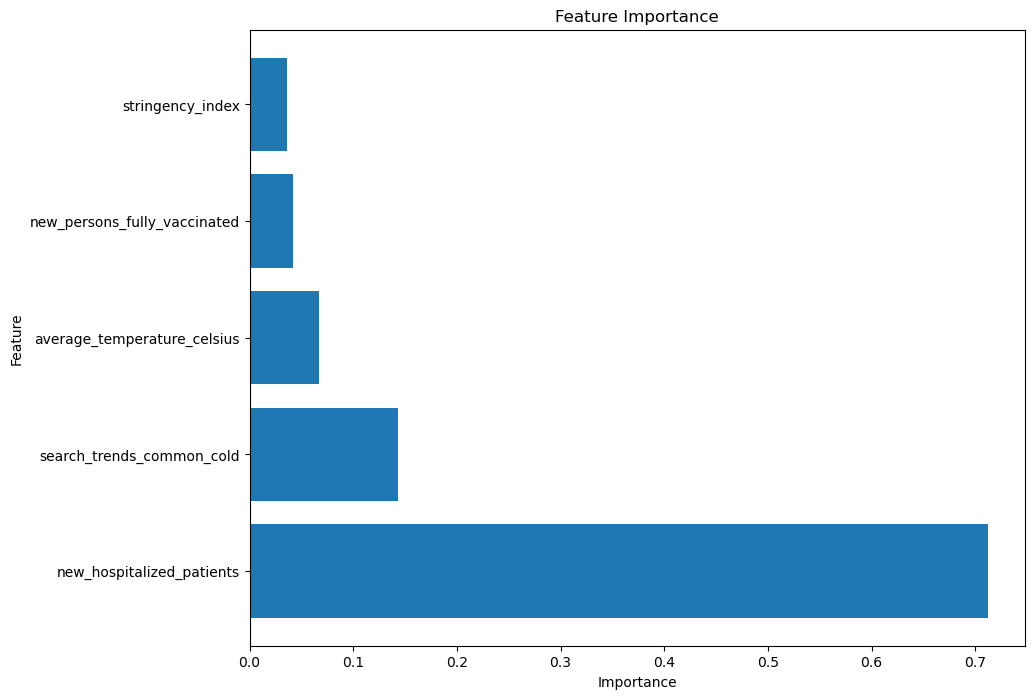

In [21]:
import matplotlib.pyplot as plt

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importances_df['feature'], importances_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
R2: 0.8143
Test RMSE: 12844.8294
Cross-Validation RMSE: 13451.8538 (+/- 3281.8598)


c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


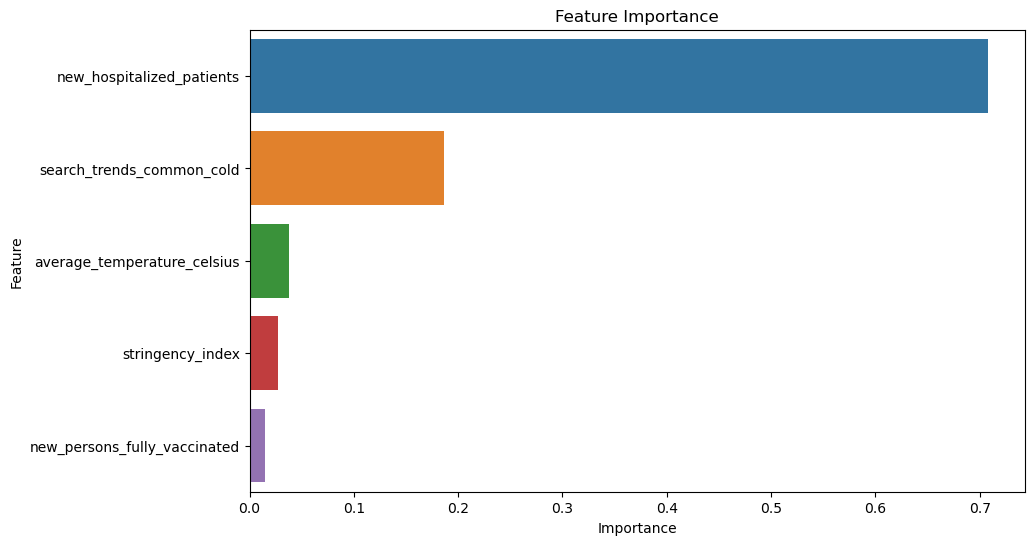

                        Feature  Importance
0     new_hospitalized_patients    0.707508
4     search_trends_common_cold    0.186236
3   average_temperature_celsius    0.037484
2              stringency_index    0.027336
1  new_persons_fully_vaccinated    0.014481
Random Forest AIC: 21226.3186
Test MAE: 3650.5932


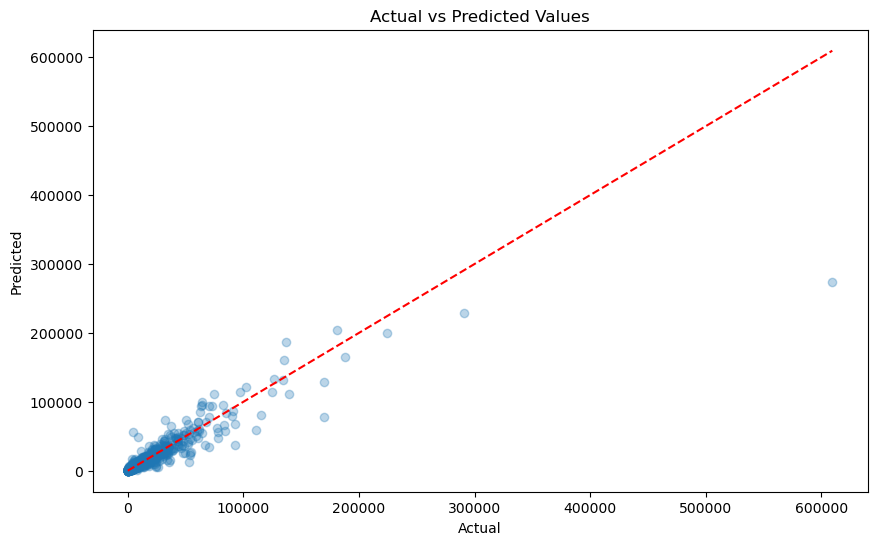

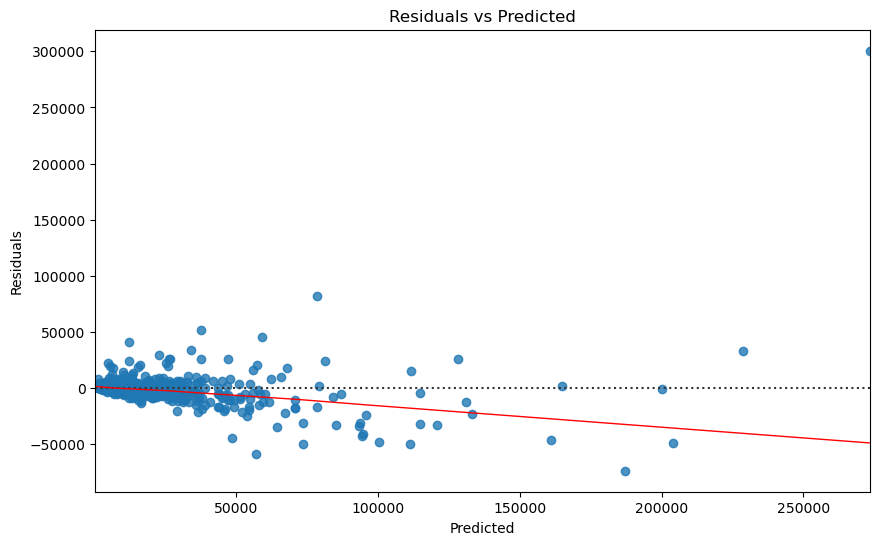

c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

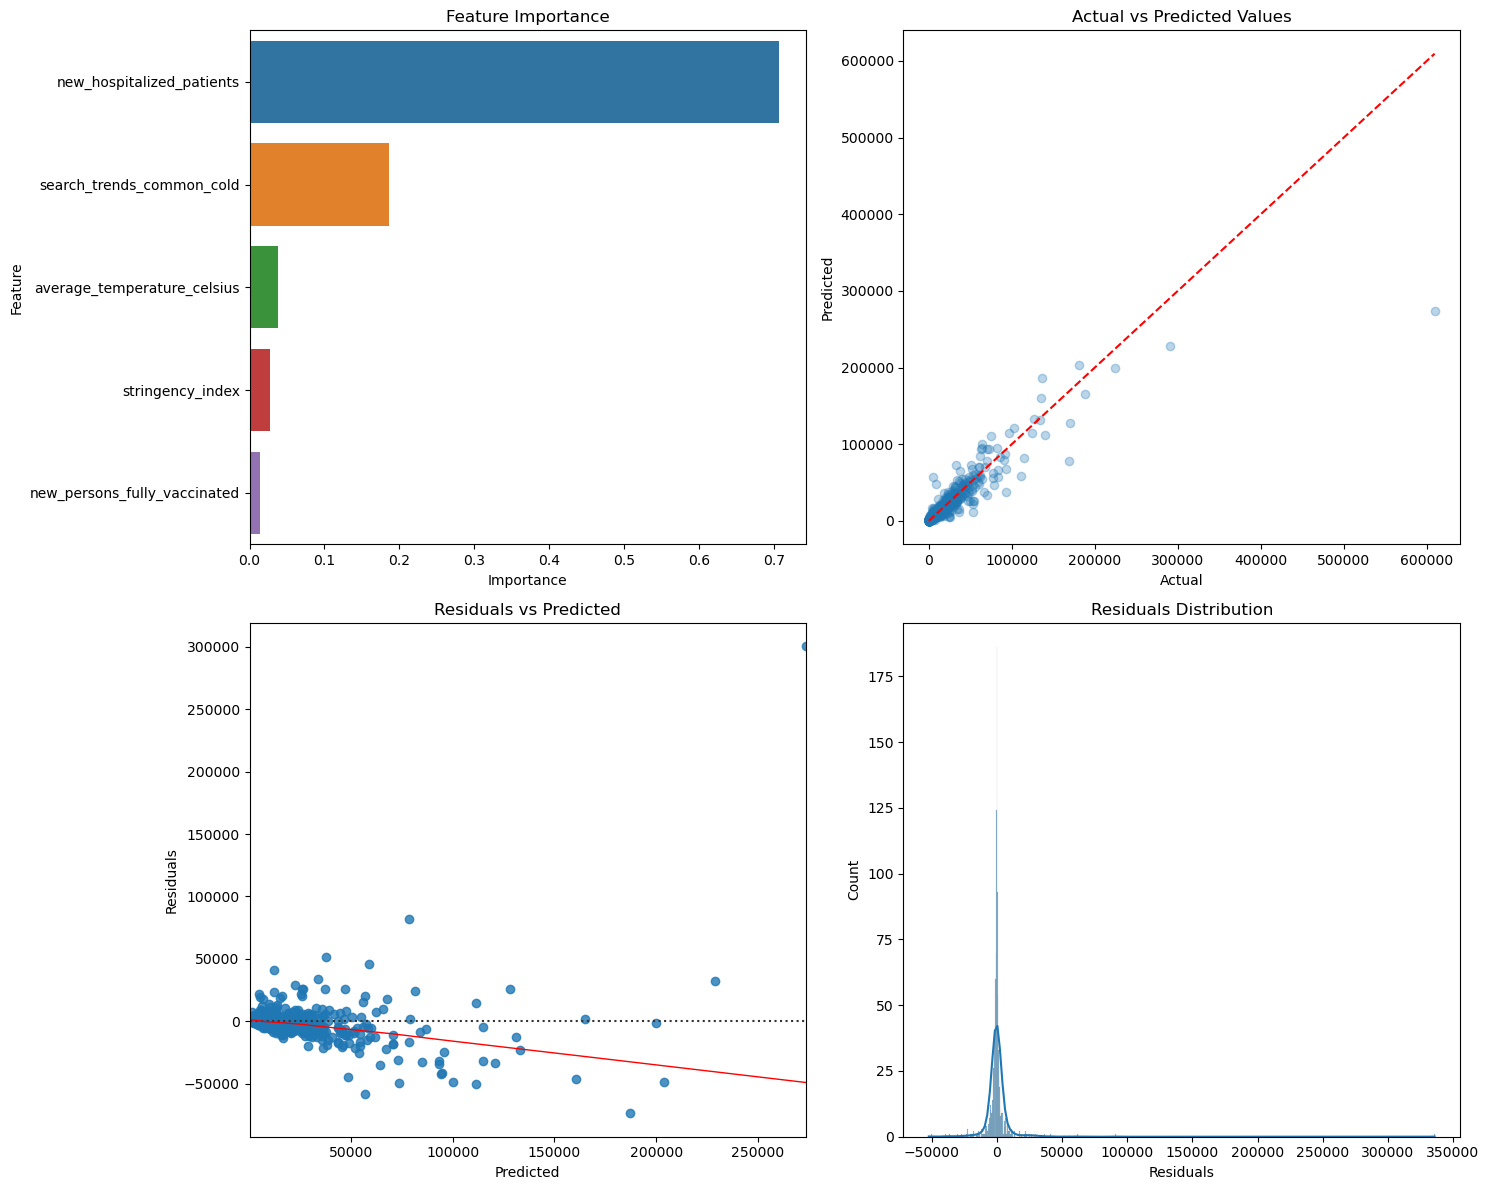

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('week5_data/weekly_aggregated_sup_data.csv')

# Exclude territories
territories_to_exclude = ['US_GU', 'US_VI', 'US_AS', 'US_PR', 'US_MP', 'US_DC']
df = df[~df['location_key'].isin(territories_to_exclude)]

# Create dummy variables for each state
state_dummies = pd.get_dummies(df['location_key'], prefix='state')

# Select predictors and target variable
selected_variables = [
    'new_hospitalized_patients', 
    'new_persons_fully_vaccinated',
    'stringency_index', 
    'average_temperature_celsius', 
    'search_trends_common_cold',
]
X = df[selected_variables].join(state_dummies)
y = df['inc cases'].astype(float).fillna(df['inc cases'].mean())

# Drop rows with missing values in any selected variable or the target
data_cleaned = X.apply(lambda col: col.fillna(col.mean()), axis=0)
y_cleaned = y.loc[data_cleaned.index]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_cleaned)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cleaned, test_size=0.2, random_state=42)

# Grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Evaluate the best model
y_pred = best_rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

# Print evaluation metrics
print(f'R2: {r2:.4f}')
print(f'Test RMSE: {rmse:.4f}')
print(f'Cross-Validation RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std():.4f})')

# Feature importance
feature_importances = best_rf_model.feature_importances_
features = data_cleaned.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Exclude state dummy variables from feature importance
importance_df_filtered = importance_df[~importance_df['Feature'].str.startswith('state_')]
importance_df_filtered = importance_df_filtered.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_filtered)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Print feature importance
print(importance_df_filtered)

# AIC calculation
n = len(y_test)
rss = np.sum((y_test - y_pred) ** 2)
k_rf = len(best_rf_model.estimators_) + 1
aic_rf = n * np.log(rss / n) + 2 * k_rf
print(f'Random Forest AIC: {aic_rf:.4f}')

# Additional model evaluation metrics
test_mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {test_mae:.4f}')

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

# Comprehensive plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Feature importance
sns.barplot(ax=axes[0, 0], x='Importance', y='Feature', data=importance_df_filtered)
axes[0, 0].set_title('Feature Importance')
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_ylabel('Feature')

# Actual vs Predicted
axes[0, 1].scatter(y_test, y_pred, alpha=0.3)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0, 1].set_title('Actual vs Predicted Values')
axes[0, 1].set_xlabel('Actual')
axes[0, 1].set_ylabel('Predicted')

# Residual plot
sns.residplot(ax=axes[1, 0], x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
axes[1, 0].set_title('Residuals vs Predicted')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Residuals')

# Residual histogram
sns.histplot(ax=axes[1, 1], x=residuals, kde=True)
axes[1, 1].set_title('Residuals Distribution')
axes[1, 1].set_xlabel('Residuals')

plt.tight_layout()
plt.show()

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
R2: 0.9084
Test RMSE: 8548.4846
Cross-Validation RMSE: 13186.2095 (+/- 2855.3938)


c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


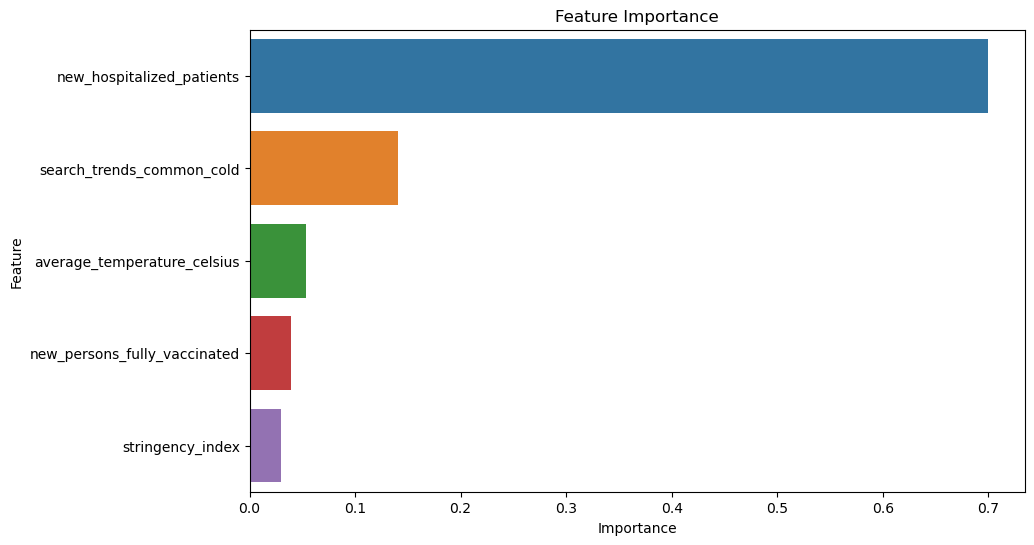

                        Feature  Importance
0     new_hospitalized_patients    0.699246
4     search_trends_common_cold    0.140630
3   average_temperature_celsius    0.053102
1  new_persons_fully_vaccinated    0.039187
2              stringency_index    0.029930
Random Forest AIC: 22510.6697
Test MAE: 3148.9040


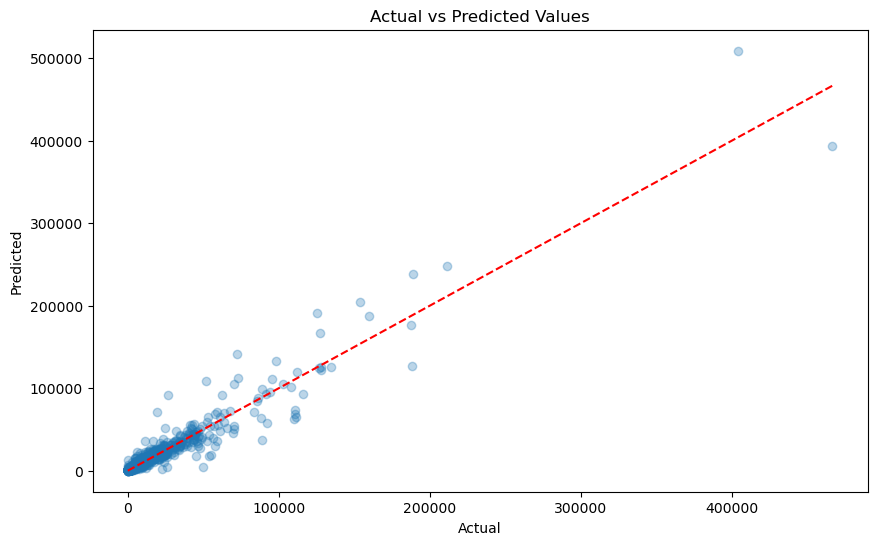

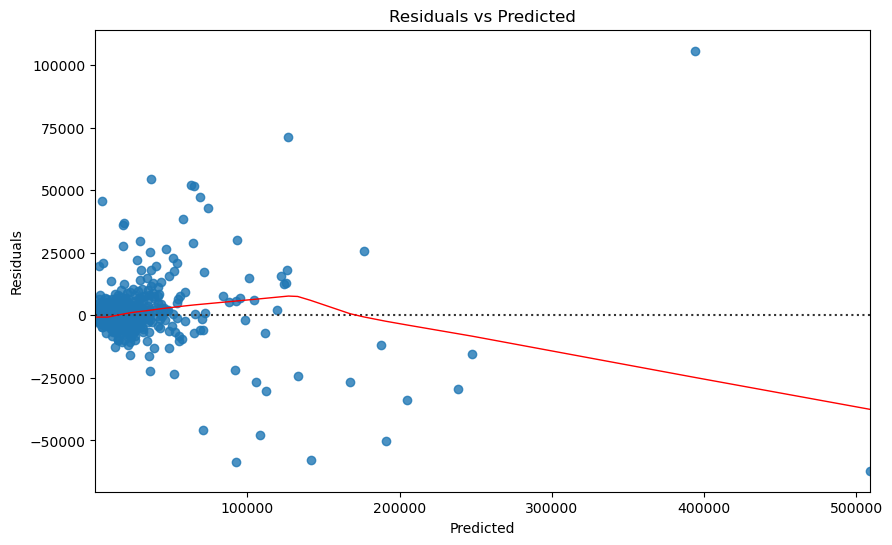

c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

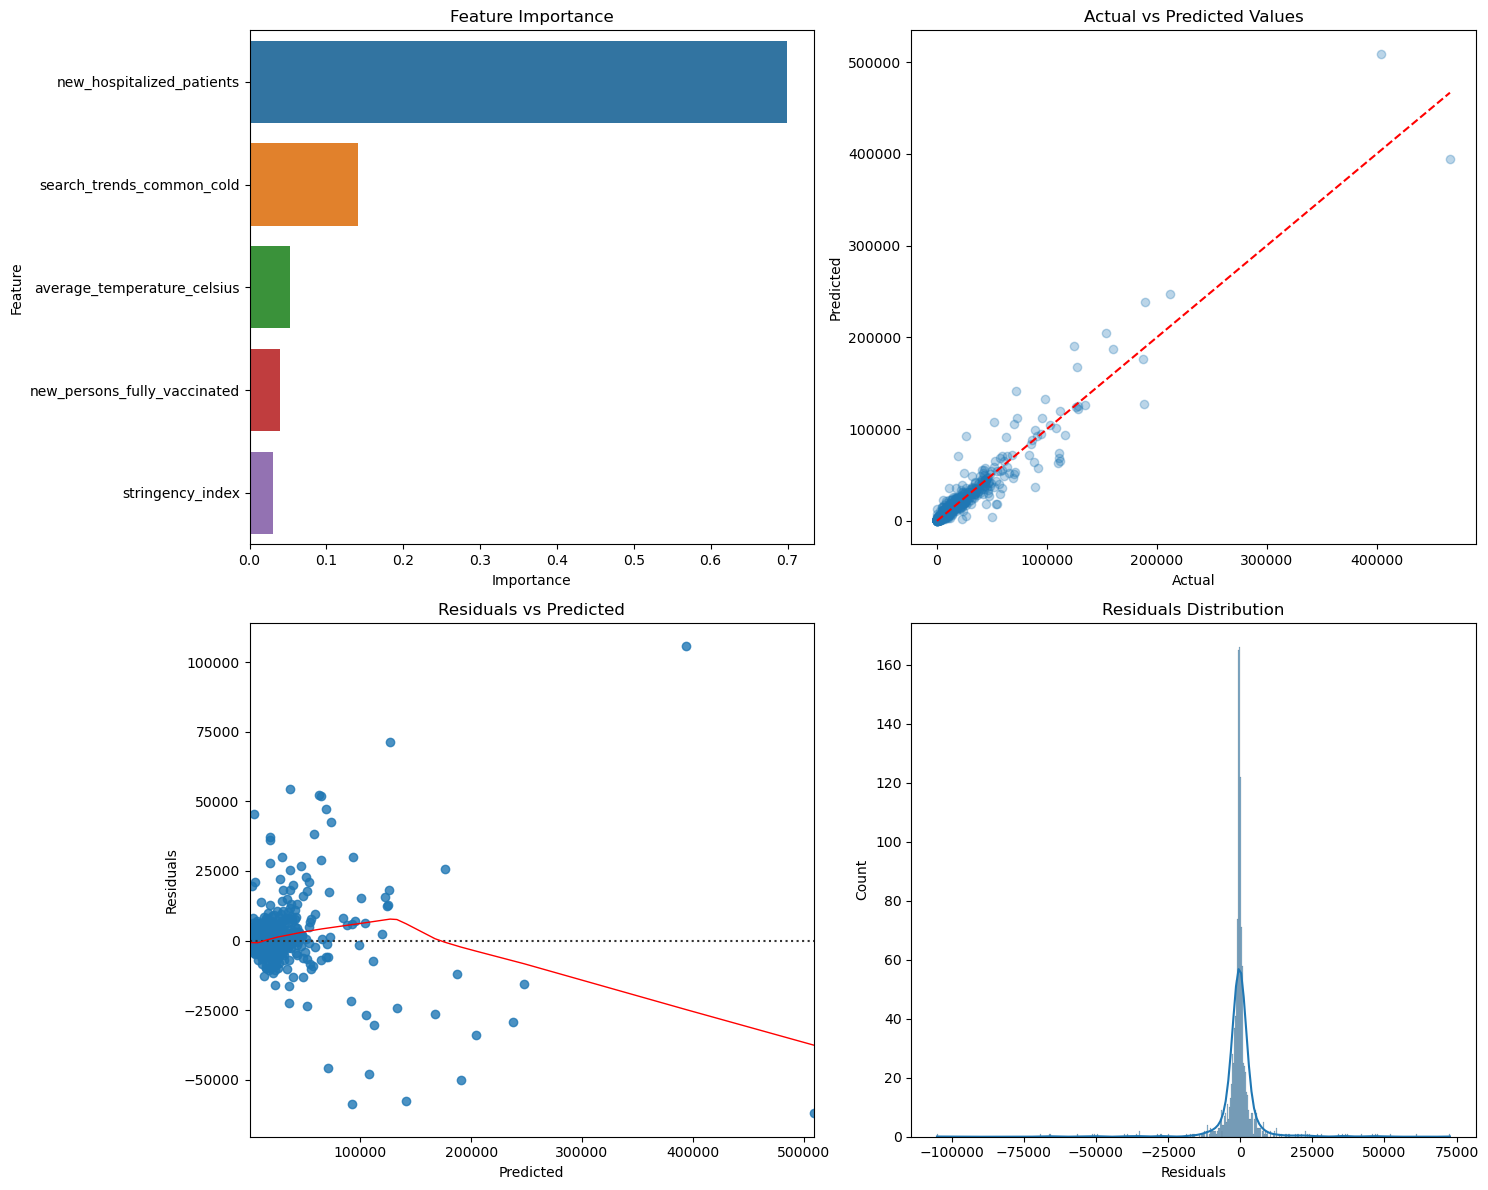

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('week5_data/weekly_aggregated_sup_data.csv')

# Create dummy variables for each state
state_dummies = pd.get_dummies(df['location_key'], prefix='state')

# Select predictors and target variable
selected_variables = [
    'new_hospitalized_patients', 
    'new_persons_fully_vaccinated',
    'stringency_index', 
    'average_temperature_celsius', 
    'search_trends_common_cold',
]
X = df[selected_variables].join(state_dummies)
y = df['inc cases'].astype(float).fillna(df['inc cases'].mean())

# Drop rows with missing values in any selected variable or the target
data_cleaned = X.apply(lambda col: col.fillna(col.mean()), axis=0)
y_cleaned = y.loc[data_cleaned.index]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_cleaned)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cleaned, test_size=0.2, random_state=42)

# Grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Evaluate the best model
y_pred = best_rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

# Print evaluation metrics
print(f'R2: {r2:.4f}')
print(f'Test RMSE: {rmse:.4f}')
print(f'Cross-Validation RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std():.4f})')

# Feature importance
feature_importances = best_rf_model.feature_importances_
features = data_cleaned.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Exclude state dummy variables from feature importance
importance_df_filtered = importance_df[~importance_df['Feature'].str.startswith('state_')]
importance_df_filtered = importance_df_filtered.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_filtered)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Print feature importance
print(importance_df_filtered)

# AIC calculation
n = len(y_test)
rss = np.sum((y_test - y_pred) ** 2)
k_rf = len(best_rf_model.estimators_) + 1
aic_rf = n * np.log(rss / n) + 2 * k_rf
print(f'Random Forest AIC: {aic_rf:.4f}')

# Additional model evaluation metrics
test_mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {test_mae:.4f}')

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

# Comprehensive plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Feature importance
sns.barplot(ax=axes[0, 0], x='Importance', y='Feature', data=importance_df_filtered)
axes[0, 0].set_title('Feature Importance')
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_ylabel('Feature')

# Actual vs Predicted
axes[0, 1].scatter(y_test, y_pred, alpha=0.3)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0, 1].set_title('Actual vs Predicted Values')
axes[0, 1].set_xlabel('Actual')
axes[0, 1].set_ylabel('Predicted')

# Residual plot
sns.residplot(ax=axes[1, 0], x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
axes[1, 0].set_title('Residuals vs Predicted')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Residuals')

# Residual histogram
sns.histplot(ax=axes[1, 1], x=residuals, kde=True)
axes[1, 1].set_title('Residuals Distribution')
axes[1, 1].set_xlabel('Residuals')

plt.tight_layout()
plt.show()